### Dec 10th, Monday, Summary
- Exposure signal data and 13 features' data are collected for all fibers in the sampled kilo-sky
- The resulted pandas table is converted to HDF5
- Next step to build the training and testing set and fit with neutral network with sklearn
- The current HDF5 file can be read in this notebook only

### Initialization

In [617]:
import operator as op

#### Bossdata

In [2]:
import bossdata
print(bossdata.__version__)

0.3.1


In [3]:
import bossdata.path
import bossdata.remote
import bossdata.meta as meta
import bossdata.spec as spec
import bossdata.plate as plate

#### Astropy

In [4]:
import astropy.io.fits as fits
from astropy.table import unique,Table

#### Pandas

In [426]:
import pandas as pd

#### Numpy

In [282]:
import numpy as np

#### HDPF5
Hierarchical Data Format

In [1124]:
import h5py

In [1127]:
import tables

In [1128]:
from tables import *

#### Environment

In [10]:
import os
workdir = os.environ['SCRATCH']
os.environ["BOSS_DATA_URL"] = 'http://dr12.sdss3.org'
os.environ["BOSS_LOCAL_ROOT"] = os.path.join(workdir,'sdss')
os.environ["BOSS_SAS_PATH"] = '/sas/dr12/boss'
os.environ["BOSS_REDUX_VERSION"]='v5_7_0'

In [6]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

In [7]:
os.chdir(workdir)

In [8]:
os.getcwd()

'/scratch/kunjias'

In [11]:
workdir

'/scratch/kunjias'

### spAll

In [12]:
spAll_path = finder.get_sp_all_path(lite=False)

In [13]:
spAll_path

'/sas/dr12/boss/spectro/redux/v5_7_0/spAll-v5_7_0.fits'

In [14]:
spAll_file = mirror.get(spAll_path, progress_min_size=2, auto_download=True, local_paths=None)

In [15]:
spAll_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/spAll-v5_7_0.fits'

In [16]:
local_path = 'home/kunjias/scratch'

In [17]:
meta.create_meta_full(catalog_path = spAll_file,db_path= local_path,verbose=True, primary_key='(PLATE,MJD,FIBER)')

/project/6016730/mlhaa/lib/python3.6/site-packages/bossdata/meta.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(dtype, np.float):
/project/6016730/mlhaa/lib/python3.6/site-packages/bossdata/meta.py:63: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  elif np.issubdtype(dtype, np.str) or np.issubdtype(dtype, np.bytes_):
Writing 100%|#################################################################|


### Bossdata.meta Database
Initialize searchable databse of BOSS observation metadata.

In [18]:
spAll= bossdata.meta.Database(finder=finder, mirror=mirror, lite=False, quasar_catalog=False, quasar_catalog_name=None, platelist=False, verbose=False)

In [19]:
columns = spAll.prepare_columns('*')

In [550]:
#columns

Fetch results of feature information using SQL Select Query.

| name  | description | file source |
|------ |-----------| -----------|
| XFOCAL | Hole x-axis position in focal plane (mm) | plPlugMap |
| YFOCAL | Hole y-axis position in focal plane (mm) | plPlugMap |
| PLATE | Plate ID | spZbest |
| MJD   | Modified Julian date of observation | spZbest |
| FIBER | Fiber ID | spZbest |
| RA | Right ascension of telescope boresights(deg) | photoObj |
| DEC | Declination of telescope boresight (deg) | photoObj |
| OBJTYPE | Why this Object was targetted (Note that if this field says QSO, it could be the case that this object would have been targetted as a GALAXY or any number of other categories as well. )| spZbest |
| AIRMASS_0 | Airmass at time of observation | photoObj |
| AIRMASS_1 |-- | --|
| AIRMASS_2 | --| --|
| AIRMASS_3 |-- |-- |
| AIRMASS_4 |-- |-- |

| SEEING 20 |                                   |
| SEEING 50 |                                     |
| SEEING 80 |                                      |

In [61]:
columns_names ='PLATE,MJD, XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4'

In [65]:
columns_names

'PLATE,MJD, XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4'

In [ ]:
len(columns_names)

In [78]:
features_spAll = spAll.select_all(what = columns_names,where=None,sort=None,max_rows=None)

In [ ]:
features_spAll.head()

In [198]:
# Turn Astropy Table into Pandas
features_data = features_spAll.to_pandas()

In [199]:
features_data.head()

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4
0,3586,55181,290.408325,-100.942619,1,9.331912,-0.462955,GALAXY,1.393166,1.402038,1.384556,1.388828,1.397564
1,3586,55181,290.107849,-136.131714,2,9.330078,-0.624116,GALAXY,1.396166,1.405074,1.387519,1.391808,1.400582
2,3586,55181,312.338440,-53.472435,3,9.432106,-0.245182,GALAXY,1.195513,1.196438,1.194720,1.195100,1.195959
3,3586,55181,311.341522,-74.466339,4,9.427406,-0.341407,SPECTROPHOTO_STD,1.196825,1.197752,1.196030,1.196411,1.197272
4,3586,55181,298.426758,-73.963768,5,9.368675,-0.339224,GALAXY,1.196795,1.197722,1.196000,1.196381,1.197242


In [200]:
# Object types of all fibers
features_data['OBJTYPE'].unique()

array(['GALAXY', 'SPECTROPHOTO_STD', 'SKY', 'QSO', 'NA'], dtype=object)

Select out the sky fibers

In [201]:
sky_fibers = features_data[(features_data['OBJTYPE'] == 'SKY')]

In [551]:
#sky_fibers

In [203]:
sky_fibers.head()

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4
11,3586,55181,305.141815,-30.619471,12,9.399483,-0.140439,SKY,0.00000,0.000000,0.000000,0.000000,0.000000
13,3586,55181,311.175537,-9.341264,14,9.426984,-0.042847,SKY,0.00000,0.000000,0.000000,0.000000,0.000000
25,3586,55181,267.770142,-53.615555,26,9.228573,-0.246457,SKY,1.19553,1.196456,1.194738,1.195118,1.195977
45,3586,55181,230.368332,-218.913437,46,9.056336,-1.003750,SKY,0.00000,0.000000,0.000000,0.000000,0.000000
47,3586,55181,225.774734,-207.749695,48,9.035569,-0.952847,SKY,0.00000,0.000000,0.000000,0.000000,0.000000


Randomly select 1000 sky fibers to retreive their exposure information.

Random state is set to 5 to for reproducibility.

In [205]:
kilo_sky = sky_fibers.sample(n=1000,replace=False,weights=None, random_state=5, axis=0)

In [208]:
kilo_sky.head()

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4
169565,3844,55321,-93.327362,140.945984,566,180.403340,0.647407,SKY,0.0,0.0,0.0,0.0,0.0
1293639,5399,55956,-119.386322,150.762390,640,185.173420,12.159917,SKY,0.0,0.0,0.0,0.0,0.0
1758203,6190,56210,60.237095,-182.178345,204,6.769615,11.811333,SKY,0.0,0.0,0.0,0.0,0.0
2208918,6822,56711,148.396866,174.016495,919,204.210510,64.690726,SKY,0.0,0.0,0.0,0.0,0.0
2461169,7451,56739,86.115021,-190.730453,170,120.395440,-0.875818,SKY,0.0,0.0,0.0,0.0,0.0


Initialize empty exposure masked array of shape (1,4128) using the first row in the sampled kilo-sky table. [plate 3586, mjd 55181, exposure 0, fiber 12].

In [413]:
plate3586_combined_plan_path = finder.get_plate_plan_path(plate=3586, mjd =55181, combined=True)
plate3586_combined_plan_file = mirror.get(plate3586_combined_plan_path, progress_min_size=2,auto_download=True, local_paths=None)
plate3586_combined_plan = plate.Plan(plate3586_combined_plan_file)

plate3586_exposures = plate3586_combined_plan.num_science_exposures
plate3586_fiber12_spectrograph_index = plate3586_combined_plan.get_spectrograph_index(12)

plate3586_exp0_spCFrame_path = plate3586_combined_plan.get_exposure_name(sequence_number=0, band='red',fiber=12,ftype='spCFrame')
plate3586_exp0_spCFrame_file = mirror.get(plate3586_exp0_spCFrame_path)

plate3586_exp0_frame = plate.FrameFile(plate3586_exp0_spCFrame_file,index=plate3586_fiber12_spectrograph_index,calibrated=True)
plate3586_valid_spec = plate3586_exp0_frame.get_valid_data(fibers=[12],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

empty_data_plate3586 = np.ma.empty_like(plate3586_valid_spec)
empty_data_plate3586.shape

(1, 4128)

In [414]:
plate3586_exposures

7

In [415]:
plate3586_fiber12_spectrograph_index

1

In [608]:
exposure = empty_data_plate3586

for n in range(plate3586_exposures):
    try:
        exp_spCFrame_path = plate3586_combined_plan.get_exposure_name(sequence_number = n,band='red',fiber=12,ftype='spCFrame')
        exp_spCFrame_file = mirror.get(exp_spCFrame_path)
        exp_frame = plate.FrameFile(exp_spCFrame_file, index =plate3586_fiber12_spectrograph_index, calibrated = True)
        valid_spec = exp_frame.get_valid_data(fibers = [12],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)
        exposure = np.ma.append(exposure,valid_spec,0)
    except Exception:
        pass
    
print(exposure.shape)

(8, 4128)


Retrieve exposure data for each one of the 1000 randomly selected sky fiber. The first row of sample empty data will be removed.

In [921]:
def get_valid_data(plate_number, mjd, fiber_number):
    '''Compute masked array of valid data from a given plate at specific mjd and exposure time.
    
    Parameters
    -----------
    plate_number: Specified plate number. Default plate number is 4042.
    
    mjd: modified julian date of the observation associated with input plate. Default mjd is 55626.
    
    fiber_number: fiber number to identify which spectrograph to retreive the exposure data,
    1-500 for spectrograph 1, and 501-1000 for spectrograph 2.
    
    Output
    -------
    A masked array of valid data of the input plate at specified exposure.
    '''
    # Get local path to plan file
    combined_plan_path = finder.get_plate_plan_path(plate_number,mjd, combined=True)
    combined_plan_file = mirror.get(combined_plan_path, progress_min_size=2,auto_download=True, local_paths=None)
    # Configuring BOSS pipeline to combine exposures of a single plate
    combined_plan = plate.Plan(combined_plan_file)
    # Number of Science Exposure
    exposures = combined_plan.num_science_exposures
    # Spectrograph Index
    spectrograph_index = combined_plan.get_spectrograph_index(fiber_number)
    
    exposure_data = empty_data_plate3586
    
    for n in range(exposures):
        try:
            exp_spCFrame_path = combined_plan.get_exposure_name(sequence_number=n,band='red',fiber=fiber_number,ftype='spCFrame')
            exp_spCFrame_file = mirror.get(exp_spCFrame_path)
            exp_frame = plate.FrameFile(exp_spCFrame_file, index = spectrograph_index, calibrated = True)
            valid_spec = exp_frame.get_valid_data(fibers =[fiber_number],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)
        
            exposure_data = np.ma.append(exposure_data,valid_spec,0)
        except Exception:
            pass
    
    print("Plate", plate_number, "fiber", fiber_number,"has", exposures, "exposures")
    return np.delete(exposure_data,0,0), exposures

In [917]:
plate3586_fiber12 = get_valid_data(plate_number=3586, mjd=55181, fiber_number=12)

Plate 3586 fiber 12 has 7 exposures


In [920]:
plate3586_fiber12[0].shape

(7, 4128)

In [919]:
plate3586_fiber12[1]

7

In [611]:
type(plate3586_fiber12)

numpy.ma.core.MaskedArray

First row in the kilo-sky table. (Plate 3844, fiber 566)

In [613]:
# Exposure Data
plate3844_fiber566 = get_valid_data(plate_number=3844, mjd=55321, fiber_number=566)

Plate 3844 fiber 566 has 4 exposures


In [614]:
plate3844_fiber566.shape

(4, 4128)

In [674]:
plate3844_fiber566[0]

masked_array(data=[(5188.4326171875, 0.0, -5.098606405780012e-15, 0.0),
                   (5189.7265625, 0.0, 203.425048828125, 0.0),
                   (5191.0205078125, 0.0, 0.0, 0.0), ...,
                   (11005.63671875, 0.0, 0.0, 0.0),
                   (11007.041015625, 0.0, 0.0, 0.0),
                   (11008.4462890625, 0.0, 0.0, 0.0)],
             mask=[(False, False, False, False),
                   (False, False, False, False),
                   (False, False, False, False), ...,
                   (False, False, False, False),
                   (False, False, False, False),
                   (False, False, False, False)],
       fill_value=(1.e+20, 1.e+20, 1.e+20, 1.e+20),
            dtype=[('wavelength', '<f4'), ('flux', '<f4'), ('ivar', '<f4'), ('sky', '<f4')])

There are 4 available exposures from red band of plate 3844, spectrograph 1. All 4 of the exposures are successfully looped through, giving a valid data matrix of shape (4,4128). 

Similar procedures will be applied to all sky fibers from the sampled kilo-sky and retrieved their exposure information.

The corresponding exposure index can be added as a 13th feature to the table, and the exposure valid data columns can be added as additional 4128 features.

The valid data masked array contains 4 fields, 'wavelength', 'flux','ivar', and 'subtracted sky'. The total flux is sum of 'flux' and 'subtracted sky'.

In [679]:
def get_field(valid_data):
    "Compute masked array of wavelength and flux from a given masked array of valid data."
    wavelength = valid_data['wavelength']
    sdss_flux = valid_data['flux']
    sdss_sky = valid_data['sky']
    total_flux = np.ma.array(sdss_flux.data+sdss_sky.data, mask=list(map(op.and_,sdss_flux.mask,sdss_sky.mask)))
    ivar = valid_data['ivar']
    
    yield [wavelength, 'wavelength']
    yield sdss_flux
    yield sdss_sky
    yield total_flux
    yield ivar

In [680]:
p3844_f566_lambda, p3844_f566_sdss_flux, p3844_f566_sdss_sky, p3844_f566_total_flux, p3844_f566_ivar= get_field(plate3844_fiber566)

In [681]:
p3844_f566_lambda.shape

(4, 4128)

In [682]:
type(p3844_f566_lambda)

numpy.ma.core.MaskedArray

A function to create a list of 4128 column names.

In [683]:
def column_index(column_name,n):
    column=[]
    for i in range(1,n+1):
        a = '{}{}'.format(column_name,i)
        column.append(a)
    return column

In [651]:
wavelength_column = column_index('wavelength',4128)

In [656]:
sdss_flux_column = column_index('sdss_flux',4128)

In [657]:
sdss_sky_column = column_index('sdss_sky',4128)

In [658]:
total_flux_column = column_index('total_flux',4128)

In [684]:
ivar_column = column_index('inverse variance', 4128)

A function to create data frame from input masked array.

In [895]:
def masked_dataframe(masked_array, name):
    ''' name: string. Name of column index
    
    Return: pandas table of masked_array
    '''
    column_name = column_index(name, 4128)

    pandas_table = pd.DataFrame(masked_array, columns = column_name).mask(masked_array.mask)
    pandas_table.insert(4128, 'exposure_index', np.arange(4))
    pandas_table = pandas_table.set_index('exposure_index')
    
    return pandas_table

In [896]:
masked_dataframe(p3844_f566_lambda, 'wavelength')

,wavelength1,wavelength2,wavelength3,wavelength4,wavelength5,wavelength6,wavelength7,wavelength8,wavelength9,wavelength10,...,wavelength4119,wavelength4120,wavelength4121,wavelength4122,wavelength4123,wavelength4124,wavelength4125,wavelength4126,wavelength4127,wavelength4128
exposure_index,,,,,,,,,,,,,,,,,,,,,
0,5188.432617,5189.726562,5191.020508,5192.314941,5193.608887,5194.903320,5196.197754,5197.492188,5198.787109,5200.082031,...,10995.800781,10997.206055,10998.611328,11000.016602,11001.421875,11002.826172,11004.231445,11005.636719,11007.041016,11008.446289
1,5188.263672,5189.557617,5190.851562,5192.145508,5193.439941,5194.734375,5196.028809,5197.323242,5198.617676,5199.912598,...,10995.610352,10997.015625,10998.420898,10999.825195,11001.230469,11002.635742,11004.041016,11005.445312,11006.850586,11008.254883
2,5188.016113,5189.309570,5190.603516,5191.897461,5193.191895,5194.486328,5195.780762,5197.075195,5198.369629,5199.664551,...,10995.347656,10996.752930,10998.158203,10999.563477,11000.968750,11002.374023,11003.778320,11005.183594,11006.588867,11007.993164
3,5187.699219,5188.992676,5190.286621,5191.581055,5192.875000,5194.169434,5195.463867,5196.758301,5198.052734,5199.347656,...,10995.034180,10996.439453,10997.844727,10999.250000,11000.655273,11002.060547,11003.464844,11004.870117,11006.275391,11007.679688


#### Wavelength Table

In [970]:
p3844_f556_lambda_table = pd.DataFrame(p3844_f566_lambda, columns = wavelength_column).mask(p3844_f566_lambda.mask)

In [883]:
p3844_f556_lambda_table.insert(4128, 'exposure_index',np.arange(4))

In [971]:
p3844_f556_lambda_table

,wavelength1,wavelength2,wavelength3,wavelength4,wavelength5,wavelength6,wavelength7,wavelength8,wavelength9,wavelength10,...,wavelength4119,wavelength4120,wavelength4121,wavelength4122,wavelength4123,wavelength4124,wavelength4125,wavelength4126,wavelength4127,wavelength4128
0,5188.432617,5189.726562,5191.020508,5192.314941,5193.608887,5194.903320,5196.197754,5197.492188,5198.787109,5200.082031,...,10995.800781,10997.206055,10998.611328,11000.016602,11001.421875,11002.826172,11004.231445,11005.636719,11007.041016,11008.446289
1,5188.263672,5189.557617,5190.851562,5192.145508,5193.439941,5194.734375,5196.028809,5197.323242,5198.617676,5199.912598,...,10995.610352,10997.015625,10998.420898,10999.825195,11001.230469,11002.635742,11004.041016,11005.445312,11006.850586,11008.254883
2,5188.016113,5189.309570,5190.603516,5191.897461,5193.191895,5194.486328,5195.780762,5197.075195,5198.369629,5199.664551,...,10995.347656,10996.752930,10998.158203,10999.563477,11000.968750,11002.374023,11003.778320,11005.183594,11006.588867,11007.993164
3,5187.699219,5188.992676,5190.286621,5191.581055,5192.875000,5194.169434,5195.463867,5196.758301,5198.052734,5199.347656,...,10995.034180,10996.439453,10997.844727,10999.250000,11000.655273,11002.060547,11003.464844,11004.870117,11006.275391,11007.679688


In [803]:
p3844_f556_lambda_table.shape

(4, 4129)

In [861]:
type(p3844_f556_lambda_table)

pandas.core.frame.DataFrame

In [862]:
p3844_f556_lambda_table = p3844_f556_lambda_table.set_index('exposure_index')

In [863]:
p3844_f556_lambda_table

,wavelength1,wavelength2,wavelength3,wavelength4,wavelength5,wavelength6,wavelength7,wavelength8,wavelength9,wavelength10,...,wavelength4119,wavelength4120,wavelength4121,wavelength4122,wavelength4123,wavelength4124,wavelength4125,wavelength4126,wavelength4127,wavelength4128
exposure_index,,,,,,,,,,,,,,,,,,,,,
0,5188.432617,5189.726562,5191.020508,5192.314941,5193.608887,5194.903320,5196.197754,5197.492188,5198.787109,5200.082031,...,10995.800781,10997.206055,10998.611328,11000.016602,11001.421875,11002.826172,11004.231445,11005.636719,11007.041016,11008.446289
1,5188.263672,5189.557617,5190.851562,5192.145508,5193.439941,5194.734375,5196.028809,5197.323242,5198.617676,5199.912598,...,10995.610352,10997.015625,10998.420898,10999.825195,11001.230469,11002.635742,11004.041016,11005.445312,11006.850586,11008.254883
2,5188.016113,5189.309570,5190.603516,5191.897461,5193.191895,5194.486328,5195.780762,5197.075195,5198.369629,5199.664551,...,10995.347656,10996.752930,10998.158203,10999.563477,11000.968750,11002.374023,11003.778320,11005.183594,11006.588867,11007.993164
3,5187.699219,5188.992676,5190.286621,5191.581055,5192.875000,5194.169434,5195.463867,5196.758301,5198.052734,5199.347656,...,10995.034180,10996.439453,10997.844727,10999.250000,11000.655273,11002.060547,11003.464844,11004.870117,11006.275391,11007.679688


#### SDSS_flux Table

In [972]:
p3844_f566_sdss_flux_table = pd.DataFrame(p3844_f566_sdss_flux, columns = sdss_flux_column).mask(p3844_f566_sdss_flux.mask)

In [944]:
p3844_f566_sdss_flux_table.insert(4128, 'exposure_index',np.arange(4))

In [973]:
p3844_f566_sdss_flux_table

,sdss_flux1,sdss_flux2,sdss_flux3,sdss_flux4,sdss_flux5,sdss_flux6,sdss_flux7,sdss_flux8,sdss_flux9,sdss_flux10,...,sdss_flux4119,sdss_flux4120,sdss_flux4121,sdss_flux4122,sdss_flux4123,sdss_flux4124,sdss_flux4125,sdss_flux4126,sdss_flux4127,sdss_flux4128
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [946]:
p3844_f566_sdss_flux_table.shape

(4, 4129)

In [797]:
p3844_f566_sdss_flux_table =p3844_f566_sdss_flux_table.set_index('exposure_index')

In [798]:
p3844_f566_sdss_flux_table

,sdss_flux1,sdss_flux2,sdss_flux3,sdss_flux4,sdss_flux5,sdss_flux6,sdss_flux7,sdss_flux8,sdss_flux9,sdss_flux10,...,sdss_flux4119,sdss_flux4120,sdss_flux4121,sdss_flux4122,sdss_flux4123,sdss_flux4124,sdss_flux4125,sdss_flux4126,sdss_flux4127,sdss_flux4128
exposure_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [799]:
p3844_f566_sdss_flux_table.shape

(4, 4128)

#### SDSS_sky table

In [974]:
p3844_f566_sdss_sky_table = pd.DataFrame(p3844_f566_sdss_sky, columns = sdss_sky_column).mask(p3844_f566_sdss_sky.mask)

In [948]:
p3844_f566_sdss_sky_table.insert(4128, 'exposure_index',np.arange(4))

In [808]:
p3844_f566_sdss_sky_table.shape

(4, 4129)

In [809]:
p3844_f566_sdss_sky_table =p3844_f566_sdss_sky_table.set_index('exposure_index')

In [975]:
p3844_f566_sdss_sky_table

,sdss_sky1,sdss_sky2,sdss_sky3,sdss_sky4,sdss_sky5,sdss_sky6,sdss_sky7,sdss_sky8,sdss_sky9,sdss_sky10,...,sdss_sky4119,sdss_sky4120,sdss_sky4121,sdss_sky4122,sdss_sky4123,sdss_sky4124,sdss_sky4125,sdss_sky4126,sdss_sky4127,sdss_sky4128
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [955]:
pd.concat([p3844_f566_sdss_flux_table,p3844_f566_sdss_sky_table],axis=1).drop_duplicates(['exposure_index'])

,sdss_flux1,sdss_flux2,sdss_flux3,sdss_flux4,sdss_flux5,sdss_flux6,sdss_flux7,sdss_flux8,sdss_flux9,sdss_flux10,...,sdss_sky4120,sdss_sky4121,sdss_sky4122,sdss_sky4123,sdss_sky4124,sdss_sky4125,sdss_sky4126,sdss_sky4127,sdss_sky4128,exposure_index
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [957]:
4129*2-1

8257

#### TOTAL_flux table

In [976]:
p3844_f566_total_flux_table = pd.DataFrame(p3844_f566_total_flux, columns = total_flux_column).mask(p3844_f566_total_flux.mask)

In [812]:
p3844_f566_total_flux_table.insert(4128, 'exposure_index',np.arange(4))

In [813]:
p3844_f566_total_flux_table.shape

(4, 4129)

In [814]:
p3844_f566_total_flux_table = p3844_f566_total_flux_table.set_index('exposure_index')

In [977]:
p3844_f566_total_flux_table

,total_flux1,total_flux2,total_flux3,total_flux4,total_flux5,total_flux6,total_flux7,total_flux8,total_flux9,total_flux10,...,total_flux4119,total_flux4120,total_flux4121,total_flux4122,total_flux4123,total_flux4124,total_flux4125,total_flux4126,total_flux4127,total_flux4128
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Inverse variance Table

In [978]:
p3844_f566_inverse_variance_table = pd.DataFrame(p3844_f566_ivar, columns = ivar_column).mask(p3844_f566_ivar.mask)

In [820]:
p3844_f566_inverse_variance_table.insert(4128, 'exposure_index',np.arange(4))

In [822]:
p3844_f566_inverse_variance_table.shape

(4, 4129)

In [823]:
p3844_f566_inverse_variance_table =p3844_f566_inverse_variance_table.set_index('exposure_index')

In [1014]:
p3844_f566_inverse_variance_table

,inverse variance1,inverse variance2,inverse variance3,inverse variance4,inverse variance5,inverse variance6,inverse variance7,inverse variance8,inverse variance9,inverse variance10,...,inverse variance4119,inverse variance4120,inverse variance4121,inverse variance4122,inverse variance4123,inverse variance4124,inverse variance4125,inverse variance4126,inverse variance4127,inverse variance4128
0,-5.098606e-15,203.425049,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-5.098613e-15,846050.000000,7.555357e+28,1.358576e-19,1.356316e-19,1.356319e-19,9.102080e-12,1.909675e-19,1.356316e-19,1.356316e-19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.098613e-15,809326.000000,7.555357e+28,1.358576e-19,1.356316e-19,1.356319e-19,9.102080e-12,1.909675e-19,1.356316e-19,1.356316e-19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-5.098606e-15,203.425049,2.369428e-38,2.369428e-38,2.369428e-38,2.369428e-38,2.369428e-38,2.369428e-38,2.369428e-38,2.369428e-38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Feature Table

In [999]:
# Feature Data
plate3844_fiber566_features = kilo_sky.take([0])

In [1000]:
plate3844_fiber566_features

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4
169565,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0


In [1001]:
plate3844_fiber566_features.iloc[0,1]

55321

In [1002]:
plate3844_fiber566_features_4exposures = pd.concat([plate3844_fiber566_features]*4)

In [1003]:
plate3844_fiber566_features_4exposures

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4
169565,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0
169565,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0
169565,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0
169565,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0


In [1004]:
plate3844_fiber566_features_4exposures.shape

(4, 13)

Add a column of exposure index as a last column. (For fiber 566 in plate 3844, there are 4 exposures)

In [1005]:
plate3844_fiber566_features_4exposures.insert(13, 'exposure_index',np.arange(4))

In [1006]:
plate3844_fiber566_features_4exposures =plate3844_fiber566_features_4exposures.set_index('exposure_index')

In [1007]:
plate3844_fiber566_features_4exposures

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4
exposure_index,,,,,,,,,,,,,
0,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0
1,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0
2,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0
3,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0


In [1012]:
plate3844_fiber566_features_4exposures.shape

(4, 13)

In [1026]:
plate3844_fiber566_frames = [plate3844_fiber566_features_4exposures, p3844_f556_lambda_table, p3844_f556_sdss_flux_table,p3844_f566_sdss_sky_table,p3844_f566_total_flux_table,p3844_f566_inverse_variance_table]

In [1027]:
plate3844_fiber566_4exposures = pd.concat(plate3844_fiber566_frames,axis=1)

In [1028]:
plate3844_fiber566_4exposures

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,...,inverse variance4119,inverse variance4120,inverse variance4121,inverse variance4122,inverse variance4123,inverse variance4124,inverse variance4125,inverse variance4126,inverse variance4127,inverse variance4128
exposure_index,,,,,,,,,,,,,,,,,,,,,
0,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1015]:
13+4128*5

20653

In [1016]:
5*4128+13

20653

In [1035]:
plate3844_fiber566_4exposures

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,...,inverse variance4119,inverse variance4120,inverse variance4121,inverse variance4122,inverse variance4123,inverse variance4124,inverse variance4125,inverse variance4126,inverse variance4127,inverse variance4128
exposure_index,,,,,,,,,,,,,,,,,,,,,
0,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Above is the exposure information table for plate 3844, fiber 566 including 13 features and all exposure valid data across 4 exposures.

Such information is to be collected for all sky fibers in the sampled kilo-sky.

In [1052]:
def make_dataframe(masked_array, name):
    ''' name: string. Name of column index
    
    Return: pandas table of masked_array
    '''
    column_name = column_index(name, 4128)

    pandas_table = pd.DataFrame(masked_array, columns = column_name).mask(masked_array.mask)
    
    return pandas_table

In [1029]:
def make_featureframe(feature_row, exposures):
    
    feature_table = pd.concat([feature_row] * exposures)
    feature_table.insert(13, 'exposure_index',np.arange(exposures))
    feature_table = feature_table.set_index('exposure_index')
    
    return feature_table

In [1098]:
def data_collection(kilo_sky):
    
    fiber_feature0 = kilo_sky.take([0])
    
    plate_number0 = fiber_feature0.iloc[0,0]
    mjd0 = fiber_feature0.iloc[0,1]
    fiber_number0 = fiber_feature0.iloc[0,4]
        
    valid_info0 = get_valid_data(plate_number0,mjd0,fiber_number0)
    
    valid_data0 = valid_info0[0]
    wavelength0, sdss_flux0, sdss_sky0, total_flux0, inverse_variance0 = get_field(valid_data0)
        
    exposures0 = valid_info0[1]
    
    feature_table0 = make_featureframe(fiber_feature0, exposures0)
        
    wavelength_table0 = make_dataframe(wavelength0,'wavelength')
    sdss_flux_table0 = make_dataframe(sdss_flux0,'sdss_flux')
    sdss_sky_table0 = make_dataframe(sdss_sky0, 'sdss_sky')
    total_flux_table0 = make_dataframe(total_flux0,'total_flux')
    inverse_variance_table0 = make_dataframe(inverse_variance0,'inverse_variance')
    
    frames0 = [feature_table0, wavelength_table0, sdss_flux_table0, sdss_sky_table0, total_flux_table0, inverse_variance_table0]
    
    fiber_data0 = pd.concat(frames0, axis=1)
        
    for n in range(1,kilo_sky.shape[0]):
        fiber_feature = kilo_sky.take([n])
    
        plate_number = fiber_feature.iloc[0,0]
        mjd = fiber_feature.iloc[0,1]
        fiber_number = fiber_feature.iloc[0,4]
        
        valid_info = get_valid_data(plate_number,mjd,fiber_number)
    
        valid_data = valid_info[0]
        wavelength, sdss_flux, sdss_sky, total_flux, inverse_variance = get_field(valid_data)
        
        exposures = valid_info[1]
    
        feature_table = make_featureframe(fiber_feature, exposures)
        
        wavelength_table = make_dataframe(wavelength,'wavelength')
        sdss_flux_table = make_dataframe(sdss_flux,'sdss_flux')
        sdss_sky_table = make_dataframe(sdss_sky, 'sdss_sky')
        total_flux_table = make_dataframe(total_flux,'total_flux')
        inverse_variance_table = make_dataframe(inverse_variance,'inverse_variance')
    
        frames = [feature_table, wavelength_table, sdss_flux_table, sdss_sky_table, total_flux_table, inverse_variance_table]
    
        fiber_data = pd.concat(frames, axis=1)
        
        fiber_data0 = pd.concat([fiber_data0, fiber_data],axis=0)
        
    return fiber_data0.reset_index()

In [1110]:
kilo_sky_data = data_collection(kilo_sky)

Plate 3844 fiber 566 has 4 exposures
Plate 5399 fiber 640 has 8 exposures
Plate 6190 fiber 204 has 4 exposures
Plate 6822 fiber 919 has 11 exposures
Plate 7451 fiber 170 has 13 exposures
Plate 7315 fiber 34 has 6 exposures
Plate 5384 fiber 264 has 6 exposures
Plate 7316 fiber 757 has 5 exposures
Plate 5956 fiber 878 has 7 exposures
Plate 4734 fiber 592 has 4 exposures
Plate 5119 fiber 176 has 4 exposures
Plate 4241 fiber 240 has 10 exposures
Plate 3873 fiber 668 has 3 exposures
Plate 6386 fiber 246 has 6 exposures
Plate 3794 fiber 544 has 18 exposures
Plate 4983 fiber 82 has 6 exposures
Plate 4184 fiber 828 has 4 exposures
Plate 3833 fiber 122 has 8 exposures
Plate 4901 fiber 495 has 7 exposures
Plate 4480 fiber 304 has 6 exposures
Plate 5880 fiber 432 has 4 exposures
Plate 3688 fiber 62 has 5 exposures
Plate 7417 fiber 986 has 5 exposures
Plate 7258 fiber 880 has 6 exposures
Plate 4977 fiber 164 has 3 exposures
Plate 6032 fiber 78 has 3 exposures
Plate 5785 fiber 148 has 5 exposures
P

spCFrame-r1-00122166.fits 100%|###################################|   3.6 KiB/s


Plate 4270 fiber 46 has 7 exposures
Plate 5304 fiber 630 has 5 exposures
Plate 5465 fiber 74 has 5 exposures
Plate 6669 fiber 90 has 3 exposures
Plate 5112 fiber 704 has 6 exposures
Plate 7085 fiber 916 has 5 exposures
Plate 4790 fiber 168 has 6 exposures
Plate 5480 fiber 144 has 8 exposures
Plate 4271 fiber 362 has 7 exposures
Plate 5739 fiber 514 has 3 exposures
Plate 3785 fiber 360 has 10 exposures
Plate 4447 fiber 162 has 11 exposures
Plate 3806 fiber 802 has 5 exposures
Plate 4080 fiber 932 has 5 exposures
Plate 5056 fiber 262 has 7 exposures
Plate 4724 fiber 706 has 7 exposures
Plate 6319 fiber 708 has 7 exposures
Plate 4974 fiber 944 has 3 exposures
Plate 5462 fiber 120 has 4 exposures
Plate 5140 fiber 456 has 4 exposures
Plate 6184 fiber 588 has 4 exposures
Plate 5449 fiber 734 has 3 exposures
Plate 4762 fiber 304 has 3 exposures
Plate 6675 fiber 262 has 6 exposures
Plate 4970 fiber 18 has 3 exposures
Plate 6191 fiber 234 has 4 exposures
Plate 6262 fiber 164 has 4 exposures
Pla

spCFrame-r1-00154656.fits 100%|###################################|   1.2 KiB/s
spCFrame-r1-00154657.fits 100%|###################################|   1.4 KiB/s
spCFrame-r1-00154658.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00154659.fits 100%|###################################|   3.4 KiB/s


Plate 5997 fiber 482 has 6 exposures
Plate 4288 fiber 42 has 3 exposures


spCFrame-r2-00108751.fits 100%|###################################|   2.8 KiB/s
spCFrame-r2-00108752.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00108753.fits 100%|###################################|   3.1 KiB/s
spCFrame-r2-00108754.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00108755.fits 100%|###################################|   3.7 KiB/s


Plate 3684 fiber 622 has 5 exposures
Plate 4357 fiber 170 has 4 exposures


spCFrame-r1-00131466.fits 100%|###################################|   3.2 KiB/s
spCFrame-r1-00131467.fits 100%|###################################|   3.4 KiB/s
spCFrame-r1-00131468.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00131469.fits 100%|###################################|   3.9 KiB/s


Plate 4856 fiber 208 has 4 exposures


spCFrame-r1-00154190.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00154191.fits 100%|###################################|   3.3 KiB/s
spCFrame-r1-00154192.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00154193.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00154194.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00154336.fits 100%|###################################|   3.6 KiB/s


Plate 6420 fiber 364 has 7 exposures


spCFrame-r1-00115504.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00115505.fits 100%|###################################|   3.2 KiB/s
spCFrame-r1-00115506.fits 100%|###################################|   3.3 KiB/s
spCFrame-r1-00115507.fits 100%|###################################|   3.5 KiB/s


Plate 3927 fiber 442 has 4 exposures
Plate 5709 fiber 630 has 9 exposures


spCFrame-r1-00169106.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00169107.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00169108.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00169109.fits 100%|###################################|   3.3 KiB/s
spCFrame-r1-00169110.fits 100%|###################################|   3.1 KiB/s


Plate 7259 fiber 457 has 5 exposures
Plate 4379 fiber 584 has 6 exposures


spCFrame-r2-00140067.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00140068.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00140069.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00140070.fits 100%|###################################|   3.8 KiB/s


Plate 5372 fiber 528 has 4 exposures


spCFrame-r2-00133532.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00133691.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00133692.fits 100%|###################################|   3.4 KiB/s
spCFrame-r2-00133693.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00133724.fits 100%|###################################|   3.3 KiB/s


Plate 4399 fiber 509 has 6 exposures
Plate 4414 fiber 585 has 5 exposures


spCFrame-r2-00140518.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00140519.fits 100%|###################################|   3.4 KiB/s
spCFrame-r2-00140520.fits 100%|###################################|   3.7 KiB/s


Plate 5388 fiber 887 has 3 exposures
Plate 6063 fiber 892 has 4 exposures


spCFrame-r2-00130329.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00130330.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00130331.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00130332.fits 100%|###################################|   3.7 KiB/s


Plate 3951 fiber 748 has 4 exposures


spCFrame-r2-00144263.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00144264.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00144265.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00144266.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00144267.fits 100%|###################################|   3.4 KiB/s
spCFrame-r2-00144268.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00144269.fits 100%|###################################|   3.6 KiB/s


Plate 6026 fiber 844 has 9 exposures
Plate 3587 fiber 398 has 6 exposures


spCFrame-r2-00166940.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00166941.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00166942.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00166943.fits 100%|###################################|   3.3 KiB/s


Plate 6292 fiber 554 has 4 exposures


spCFrame-r1-00130801.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00130802.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00130803.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00130804.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00130978.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00131007.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00131008.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00131032.fits 100%|###################################|   4.0 KiB/s


Plate 4741 fiber 494 has 8 exposures


spCFrame-r1-00147541.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00147542.fits 100%|###################################|   3.3 KiB/s
spCFrame-r1-00147543.fits 100%|###################################|   3.5 KiB/s


Plate 6118 fiber 362 has 3 exposures


spCFrame-r1-00143262.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00143321.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00143322.fits 100%|###################################|   3.8 KiB/s


Plate 5173 fiber 325 has 3 exposures


spCFrame-r1-00169003.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00169004.fits 100%|###################################|   3.3 KiB/s
spCFrame-r1-00169005.fits 100%|###################################|   3.3 KiB/s
spCFrame-r1-00169006.fits 100%|###################################|   3.1 KiB/s
spCFrame-r1-00169007.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00169008.fits 100%|###################################|   4.1 KiB/s


Plate 6782 fiber 435 has 6 exposures


spCFrame-r2-00124719.fits 100%|###################################|   1.9 KiB/s
spCFrame-r2-00124720.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00124721.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00124803.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00124804.fits 100%|###################################|   3.4 KiB/s


Plate 4495 fiber 530 has 5 exposures


spCFrame-r2-00161398.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00161399.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00161575.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00161576.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00161634.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00161635.fits 100%|###################################|   3.4 KiB/s


Plate 6745 fiber 694 has 7 exposures


spCFrame-r2-00135972.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00135973.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00135974.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00135975.fits 100%|###################################|   3.8 KiB/s


Plate 5284 fiber 900 has 4 exposures


spCFrame-r2-00131885.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00131886.fits 100%|###################################|   4.2 KiB/s
spCFrame-r2-00131887.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00131888.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00131889.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00131942.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00131943.fits 100%|###################################|   3.7 KiB/s


Plate 4882 fiber 920 has 7 exposures


spCFrame-r2-00144045.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00144046.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00144047.fits 100%|###################################|   4.0 KiB/s


Plate 6021 fiber 988 has 3 exposures


spCFrame-r2-00132235.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00132236.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00132237.fits 100%|###################################|   4.1 KiB/s


Plate 4712 fiber 684 has 3 exposures
Plate 4712 fiber 148 has 3 exposures


spCFrame-r1-00124918.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00124919.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00124973.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00124974.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00124975.fits 100%|###################################|   3.8 KiB/s


Plate 4558 fiber 208 has 12 exposures


spCFrame-r1-00141352.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00141353.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00141354.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00141355.fits 100%|###################################|   4.0 KiB/s


Plate 5210 fiber 206 has 4 exposures


spCFrame-r1-00141755.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00141756.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00141757.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00141758.fits 100%|###################################|   4.0 KiB/s


Plate 5475 fiber 39 has 4 exposures


spCFrame-r2-00139965.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00139966.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00139967.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00139968.fits 100%|###################################|   4.1 KiB/s


Plate 5331 fiber 908 has 4 exposures
Plate 4882 fiber 632 has 7 exposures


spCFrame-r2-00131185.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00131186.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00131187.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00131188.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00131189.fits 100%|###################################|   2.6 KiB/s


Plate 4777 fiber 884 has 5 exposures


spCFrame-r2-00114690.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00114691.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00114693.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00114694.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00114695.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00114696.fits 100%|###################################|   1.1 KiB/s


Plate 3953 fiber 602 has 7 exposures


spCFrame-r1-00120346.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00120347.fits 100%|###################################|   3.4 KiB/s
spCFrame-r1-00120415.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00120416.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00120417.fits 100%|###################################|   4.1 KiB/s


Plate 4227 fiber 437 has 5 exposures


spCFrame-r2-00128883.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00128884.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00128885.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00128886.fits 100%|###################################|   4.1 KiB/s


Plate 4620 fiber 904 has 4 exposures
Plate 6433 fiber 68 has 4 exposures
Plate 6319 fiber 626 has 7 exposures


spCFrame-r1-00131316.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00131317.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00131318.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00131319.fits 100%|###################################|   3.9 KiB/s


Plate 4893 fiber 166 has 4 exposures


spCFrame-r1-00153274.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00153275.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00153276.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00153277.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00153984.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00153985.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00153986.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00153987.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00153988.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00153989.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00153990.fits 100%|###################################|   3.8 KiB/s


Plate 6425 fiber 483 has 14 exposures


spCFrame-r1-00138130.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00138131.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00138132.fits 100%|###################################|   3.9 KiB/s


Plate 4853 fiber 276 has 3 exposures


spCFrame-r2-00148693.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00148694.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00148695.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00148696.fits 100%|###################################|   3.7 KiB/s


Plate 6131 fiber 713 has 4 exposures


spCFrame-r2-00140158.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00140243.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00140244.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00140245.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00140246.fits 100%|###################################|   3.9 KiB/s


Plate 5741 fiber 638 has 5 exposures


spCFrame-r1-00155953.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00155954.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00155955.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00155956.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00155957.fits 100%|###################################|   3.7 KiB/s


Plate 6450 fiber 358 has 5 exposures


spCFrame-r2-00123260.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00123261.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00123262.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00123263.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00123264.fits 100%|###################################|   2.8 KiB/s
spCFrame-r2-00123265.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00123266.fits 100%|###################################|   4.2 KiB/s
spCFrame-r2-00123338.fits 100%|###################################|   3.9 KiB/s


Plate 4453 fiber 548 has 9 exposures


spCFrame-r1-00111598.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00111705.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00111780.fits 100%|###################################|   4.2 KiB/s
spCFrame-r1-00111781.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00111955.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00111956.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00111957.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00111958.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00111959.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00111960.fits 100%|###################################|   3.9 KiB/s


Plate 3816 fiber 78 has 10 exposures


spCFrame-r1-00131096.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00131097.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00131098.fits 100%|###################################|   4.2 KiB/s
spCFrame-r1-00131099.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00131100.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00131101.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00131102.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00131103.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00131142.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00131143.fits 100%|###################################|   3.9 KiB/s


Plate 5006 fiber 466 has 11 exposures


spCFrame-r2-00111731.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00111732.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00111733.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00111734.fits 100%|###################################|   4.1 KiB/s


Plate 3853 fiber 944 has 4 exposures


spCFrame-r2-00124335.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00124336.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00124337.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00124338.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00124339.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00124340.fits 100%|###################################|   3.5 KiB/s


Plate 4526 fiber 748 has 6 exposures


spCFrame-r1-00139286.fits 100%|###################################|   3.4 KiB/s
spCFrame-r1-00139287.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00139288.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00139289.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00139290.fits 100%|###################################|   4.2 KiB/s


Plate 5316 fiber 40 has 5 exposures


spCFrame-r2-00127969.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00127970.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00127971.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00127972.fits 100%|###################################|   4.3 KiB/s
spCFrame-r2-00127973.fits 100%|###################################|   3.2 KiB/s


Plate 4748 fiber 912 has 5 exposures


spCFrame-r2-00177177.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00177259.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00177260.fits 100%|###################################|   4.2 KiB/s
spCFrame-r2-00177261.fits 100%|###################################|   4.2 KiB/s


Plate 7105 fiber 732 has 5 exposures


spCFrame-r2-00162510.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00162511.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00162512.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00162513.fits 100%|###################################|   1.5 KiB/s


Plate 6808 fiber 518 has 4 exposures


spCFrame-r2-00150602.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00150603.fits 100%|###################################|   4.1 KiB/s
spCFrame-r2-00150604.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00150605.fits 100%|###################################|   4.0 KiB/s


Plate 6174 fiber 594 has 4 exposures


spCFrame-r1-00129024.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00129025.fits 100%|###################################|   3.4 KiB/s
spCFrame-r1-00129026.fits 100%|###################################|   3.9 KiB/s


Plate 4707 fiber 134 has 3 exposures


spCFrame-r1-00161861.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00161862.fits 100%|###################################|   2.5 KiB/s
spCFrame-r1-00161863.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00161943.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00161944.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00161945.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00162439.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00162440.fits 100%|###################################|   3.9 KiB/s


Plate 6974 fiber 34 has 8 exposures
Plate 3615 fiber 312 has 4 exposures


spCFrame-r2-00130267.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00130268.fits 100%|###################################|   4.2 KiB/s
spCFrame-r2-00130269.fits 100%|###################################|   3.9 KiB/s


Plate 4864 fiber 890 has 3 exposures


spCFrame-r2-00152942.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00152943.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00152944.fits 100%|###################################|   4.2 KiB/s
spCFrame-r2-00152945.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00152946.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00152947.fits 100%|###################################|   3.2 KiB/s


Plate 6428 fiber 792 has 6 exposures


spCFrame-r1-00138319.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00138320.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00138358.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00138493.fits 100%|###################################|   4.2 KiB/s


Plate 4393 fiber 60 has 6 exposures


spCFrame-r1-00165945.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00165947.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00166015.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00166016.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00166017.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00166018.fits 100%|###################################|   4.1 KiB/s


Plate 6526 fiber 10 has 8 exposures


spCFrame-r1-00161640.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00161641.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00161642.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00161725.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00161726.fits 100%|###################################|   3.9 KiB/s


Plate 6797 fiber 348 has 5 exposures


spCFrame-r1-00148600.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00148601.fits 100%|###################################|   4.3 KiB/s
spCFrame-r1-00148602.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00148603.fits 100%|###################################|   3.8 KiB/s


Plate 6183 fiber 213 has 4 exposures


spCFrame-r2-00143327.fits 100%|###################################|   2.9 KiB/s
spCFrame-r2-00143328.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00143329.fits 100%|###################################|   3.8 KiB/s


Plate 4976 fiber 616 has 3 exposures


spCFrame-r1-00124554.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00124555.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00124556.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00124557.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00124558.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00124559.fits 100%|###################################|   3.6 KiB/s


Plate 4503 fiber 444 has 6 exposures


spCFrame-r1-00142576.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00142577.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00142578.fits 100%|###################################|   3.9 KiB/s


Plate 5203 fiber 113 has 3 exposures


spCFrame-r2-00144652.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00144653.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00144654.fits 100%|###################################|   3.4 KiB/s


Plate 5999 fiber 704 has 3 exposures


spCFrame-r1-00159833.fits 100%|###################################|   3.0 KiB/s
spCFrame-r1-00159834.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00159835.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00159836.fits 100%|###################################|   3.6 KiB/s


Plate 6720 fiber 470 has 4 exposures


spCFrame-r2-00124554.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00124555.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00124556.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00124557.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00124558.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00124559.fits 100%|###################################|   4.2 KiB/s


Plate 4503 fiber 976 has 6 exposures


spCFrame-r1-00147404.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00147405.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00147406.fits 100%|###################################|   3.4 KiB/s
spCFrame-r1-00147407.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00147408.fits 100%|###################################|   3.7 KiB/s


Plate 6168 fiber 202 has 5 exposures


spCFrame-r2-00120335.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00120336.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00120338.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00120339.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00120340.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00120341.fits 100%|###################################|   3.4 KiB/s


Plate 4219 fiber 624 has 6 exposures
Plate 4503 fiber 200 has 6 exposures


spCFrame-r2-00135753.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00135754.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00135755.fits 100%|###################################|   3.2 KiB/s
spCFrame-r2-00135756.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00135757.fits 100%|###################################|   3.4 KiB/s


Plate 4787 fiber 844 has 5 exposures


spCFrame-r2-00147702.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00147703.fits 100%|###################################|   3.2 KiB/s
spCFrame-r2-00147704.fits 100%|###################################|   3.6 KiB/s


Plate 6314 fiber 931 has 3 exposures


spCFrame-r1-00134224.fits 100%|###################################|   3.4 KiB/s
spCFrame-r1-00134225.fits 100%|###################################|   3.4 KiB/s
spCFrame-r1-00134226.fits 100%|###################################|   1.5 KiB/s
spCFrame-r1-00134227.fits 100%|###################################|   3.2 KiB/s


Plate 5022 fiber 186 has 4 exposures


spCFrame-r2-00128717.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00128718.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00128719.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00128720.fits 100%|###################################|   3.7 KiB/s


Plate 4759 fiber 980 has 4 exposures


spCFrame-r1-00165808.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00165809.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00165810.fits 100%|###################################|   3.8 KiB/s


Plate 6511 fiber 52 has 8 exposures


spCFrame-r2-00173466.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00173467.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00173468.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00173469.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00173470.fits 100%|###################################|   3.6 KiB/s


Plate 7092 fiber 952 has 5 exposures


spCFrame-r2-00123227.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00123228.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00123229.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00123380.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00123381.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00123382.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00123465.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00123466.fits 100%|###################################|   3.7 KiB/s


Plate 4363 fiber 928 has 11 exposures


spCFrame-r2-00159664.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00159665.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00159666.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00159667.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00159668.fits 100%|###################################|   3.8 KiB/s


Plate 6747 fiber 676 has 5 exposures


spCFrame-r1-00159725.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00159726.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00159727.fits 100%|###################################|   3.8 KiB/s


Plate 6676 fiber 84 has 3 exposures


spCFrame-r1-00112278.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00112279.fits 100%|###################################|   4.1 KiB/s
spCFrame-r1-00112280.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00112281.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00112282.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00112283.fits 100%|###################################|   3.7 KiB/s


Plate 3696 fiber 82 has 6 exposures


spCFrame-r2-00159200.fits 100%|###################################|   3.3 KiB/s
spCFrame-r2-00159201.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00159202.fits 100%|###################################|   3.7 KiB/s


Plate 5737 fiber 666 has 3 exposures


spCFrame-r2-00159287.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00159288.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00159289.fits 100%|###################################|   3.9 KiB/s


Plate 6664 fiber 996 has 3 exposures


spCFrame-r2-00136477.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00136478.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00136479.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00136480.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00136481.fits 100%|###################################|   2.9 KiB/s
spCFrame-r2-00136482.fits 100%|###################################|   3.7 KiB/s


Plate 4323 fiber 774 has 6 exposures


spCFrame-r2-00165798.fits 100%|###################################|   3.5 KiB/s
spCFrame-r2-00165799.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00165800.fits 100%|###################################|   3.2 KiB/s
spCFrame-r2-00165801.fits 100%|###################################|   3.9 KiB/s
spCFrame-r2-00165802.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00165803.fits 100%|###################################|   3.9 KiB/s


Plate 6504 fiber 614 has 6 exposures
Plate 3794 fiber 768 has 18 exposures


spCFrame-r1-00129031.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00129032.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00129033.fits 100%|###################################|   3.9 KiB/s


Plate 4715 fiber 428 has 3 exposures


spCFrame-r2-00133554.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00134039.fits 100%|###################################|   3.4 KiB/s
spCFrame-r2-00134040.fits 100%|###################################|   3.7 KiB/s
spCFrame-r2-00134041.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00134042.fits 100%|###################################|   2.5 KiB/s
spCFrame-r2-00134043.fits 100%|###################################|   3.7 KiB/s


Plate 5037 fiber 598 has 6 exposures


spCFrame-r1-00154745.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00154746.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00154747.fits 100%|###################################|   3.5 KiB/s


Plate 6415 fiber 458 has 3 exposures


spCFrame-r1-00135964.fits 100%|###################################|   4.0 KiB/s
spCFrame-r1-00135965.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00135966.fits 100%|###################################|   3.5 KiB/s
spCFrame-r1-00135967.fits 100%|###################################|   3.6 KiB/s


Plate 4487 fiber 96 has 4 exposures
Plate 4966 fiber 530 has 5 exposures


spCFrame-r2-00115443.fits 100%|###################################|   3.6 KiB/s
spCFrame-r2-00115444.fits 100%|###################################|   3.8 KiB/s
spCFrame-r2-00115445.fits 100%|###################################|   4.0 KiB/s
spCFrame-r2-00115446.fits 100%|###################################|   3.6 KiB/s


Plate 3930 fiber 939 has 4 exposures


spCFrame-r1-00154953.fits 100%|###################################|   3.6 KiB/s
spCFrame-r1-00154954.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00154955.fits 100%|###################################|   4.3 KiB/s
spCFrame-r1-00154956.fits 100%|###################################|   3.6 KiB/s


Plate 6423 fiber 14 has 4 exposures


spCFrame-r1-00159287.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00159288.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00159289.fits 100%|###################################|   3.6 KiB/s


Plate 6664 fiber 82 has 3 exposures


spCFrame-r1-00177758.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00177759.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00177760.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00177761.fits 100%|###################################|   3.6 KiB/s


Plate 7110 fiber 324 has 4 exposures
Plate 6027 fiber 149 has 4 exposures


spCFrame-r1-00159664.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00159665.fits 100%|###################################|   3.7 KiB/s
spCFrame-r1-00159666.fits 100%|###################################|   3.9 KiB/s
spCFrame-r1-00159667.fits 100%|###################################|   3.8 KiB/s
spCFrame-r1-00159668.fits 100%|###################################|   3.7 KiB/s


Plate 6747 fiber 92 has 5 exposures


In [1122]:
kilo_sky_data.head()

,exposure_index,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,...,inverse_variance4119,inverse_variance4120,inverse_variance4121,inverse_variance4122,inverse_variance4123,inverse_variance4124,inverse_variance4125,inverse_variance4126,inverse_variance4127,inverse_variance4128
0,0,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,...,10982.367188,10983.790039,10985.212891,10986.635742,10988.057617,10989.480469,10990.90332,10992.325195,10993.748047,10995.169922
1,1,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,2,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,...,10982.367188,10983.790039,10985.212891,10986.635742,10988.057617,10989.480469,10990.90332,10992.325195,10993.748047,10995.169922
3,3,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0,5399,55956,-119.386322,150.762390,640,185.17342,12.159917,SKY,0.0,...,7.674854,5.685881,5.342369,7.043584,4.965499,4.463652,0.00000,0.000000,0.000000,0.000000


In [1141]:
kilo_sky_data.to_hdf('kilo_sky_features.hdf5',key ='kilo_sky_data', mode='w')

In [1142]:
type(kilo_sky_data)

pandas.core.frame.DataFrame

In [1144]:
f = h5py.File('kilo_sky_features.hdf5','r')

In [1145]:
for key in f.keys():
    print(key)

kilo_sky_data


## Scratch work and history in below

##### Dec 7th, Friday, Summary
- All exposure information for the sample sky fiber is combined with its features in a pandas dataframe.
- The exposure information contains 4 fields (wavelength, sdss_sky_flux, sdss_object_flux, inverse_variance)
- Total_flux is calculated by summing sdss_sky_flux and sdss_object_flux
- Counting total_flux, there are 5 categories of exposure information, each with 4128 data points at a particular exposure.
- The sample sky fiber has a final exposure information dataframe with dimension (4,20653)
- The looping and collection of exposure data is to be repeated for all sampl

##### Dec 6th, Thursday, Summary
- The feature table with 13 columns is replicated by row corresponding to the number of available exposure in each fiber

- The exposure index column is added as the 14th column

- Exposure data matrix with 4128 columns is intended to be add as extra columns to the feature matrix. The index and value are not approriately understood by the current concatenation method. Modification is needed.

- Next step: automation for all exposure across fibers and convert to HDF5 file.

In [587]:
field_index=['wavelength','flux','ivar','sky']

In [585]:
type(plate3844_fiber566)

numpy.ma.core.MaskedArray

In [586]:
plate3844_fiber566.shape

(5, 4128)

In [599]:
plate3844_fiber566_exp0 =pd.DataFrame.from_records(data = plate3844_fiber566[1], index = field_index).T

In [600]:
plate3844_fiber566_exp0

wavelength,5188.432617,5189.726562,5191.020508,5192.314941,5193.608887,5194.903320,5196.197754,5197.492188,5198.787109,5200.082031,...,10995.800781,10997.206055,10998.611328,11000.016602,11001.421875,11002.826172,11004.231445,11005.636719,11007.041016,11008.446289
flux,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ivar,-5.098634e-15,2.108738e+02,-1.238074e+04,-6.703080e-16,1.243750e+01,4.536435e+23,1.965882e-41,0.000000e+00,-1.094270e-14,0.000000e+00,...,-3.003515e-08,-1.917936e-03,1.806464e+32,2.350989e-38,2.350989e-38,2.407412e-35,2.270622e+23,-2.958841e-03,-1.678396e-16,1.243750e+01
sky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [601]:
plate3844_fiber566_exp1 =pd.DataFrame.from_records(data = plate3844_fiber566[2], index = field_index).T

In [602]:
plate3844_fiber566_exp1

wavelength,5188.263672,5189.557617,5190.851562,5192.145508,5193.439941,5194.734375,5196.028809,5197.323242,5198.617676,5199.912598,...,10995.610352,10997.015625,10998.420898,10999.825195,11001.230469,11002.635742,11004.041016,11005.445312,11006.850586,11008.254883
flux,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ivar,-5.098613e-15,1.766016e+02,7.555357e+28,1.358576e-19,1.356316e-19,1.356319e-19,9.102080e-12,1.909675e-19,1.356316e-19,1.356316e-19,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [567]:
plate3844_fiber566 = pd.DataFrame.from_records(data = plate3844_fiber566, index= field_index).T

In [555]:
type(plate3844_fiber566_features_4exposures)

pandas.core.frame.DataFrame

In [554]:
type(plate3844_fiber566_exp0)

pandas.core.frame.DataFrame

In [543]:
first_row = plate3844_fiber566_features_4exposures.take([0])

In [544]:
first_row

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,AIRMASS_2,AIRMASS_3,AIRMASS_4,exposure_index
169565,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,0.0,0.0,0.0,0


In [545]:
result = pd.concat([first_row, plate3844_fiber566_exp0],axis=1, sort=False)

In [547]:
result

,PLATE,MJD,XFOCAL,YFOCAL,FIBER,RA,DEC,OBJTYPE,AIRMASS_0,AIRMASS_1,...,"(10995.80078125, 0.0, 2.3694275473575467e-38, 0.0)","(10997.2060546875, 0.0, 2.3694275473575467e-38, 0.0)","(10998.611328125, 0.0, 2.3694275473575467e-38, 0.0)","(11000.0166015625, 0.0, 2.3694275473575467e-38, 0.0)","(11001.421875, 0.0, 2.3694275473575467e-38, 0.0)","(11002.826171875, 0.0, 2.3694275473575467e-38, 0.0)","(11004.2314453125, 0.0, 2.3694275473575467e-38, 0.0)","(11005.63671875, 0.0, 2.3694275473575467e-38, 0.0)","(11007.041015625, 0.0, 2.3694275473575467e-38, 0.0)","(11008.4462890625, 0.0, 2.3694275473575467e-38, 0.0)"
169565,3844,55321,-93.327362,140.945984,566,180.40334,0.647407,SKY,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The 4128 columns are intended to be added to the 13 feature columns. The field and value recognition is not captured by the existing concatenation methods. Alternative ways are being seeked to acheive the desired result. The it is successful for one exposure of one fiber, the process can be automated for all exposures across fibers.

#### HDF5 File Practice

In [ ]:
with h5py.File('sky.hdf5','w') as f:
    plate = f.create_group('Plate_number')
    mjd = f.create_group('Modified_Julian_Date')
    exposure = f.create_group('Exposure_Index')
    data = f.create_group('Valid_Data')
    

###### Dec 4th, Tuesday, Summary

- The OBJECTYPE column is added to the features table, giving a total of 13 features.

- The original feature table is produced in Astropy format and converted to Pandas for the ease of operations.

- 1000 sky fibers are randomly sampled from all of the 2.4million fibers to retrieve their exposure information through bossdata.plate module.

- The sky fibers from different plates may have different number of available exposures. The corresponding number of exposures for each sampled sky fiber is retreived and looped through to obtain their valid signal data matrix.

- The current looping function is tested to work well across all exposures with the first row of the kilo-sampled-sky table.

In [225]:
plate7457_plan_path = finder.get_plate_plan_path(7457,56746, combined=True)

In [226]:
plate7457_plan_file = mirror.get(plate7457_plan_path)

In [227]:
plate7457_combined_plan = plate.Plan(plate7457_plan_file)

In [273]:
plate7457_frame =plate7457_combined_plan.get_exposure_name(2,'red',1)

In [274]:
plate7457_frame

'/sas/dr12/boss/spectro/redux/v5_7_0/7457/spCFrame-r1-00177371.fits'

In [276]:
plate7457_frame = plate.FrameFile(plate7457_frame_file, index =1, calibrated = True)

In [278]:
a = plate7457_frame.get_valid_data(fibers =[1],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [292]:
a.shape

(1, 4128)

In [28]:
plate_spAll = spAll.select_all(what='PLATE', where= None, sort=None, max_rows=None)

In [30]:
MJD_spAll = spAll.select_all(what='MJD', where= None, sort=None, max_rows=None)

In [32]:
FIBER_spAll = spAll.select_all(what='FIBER', where= None, sort=None, max_rows=None)

In [37]:
AIRMASS_0_spAll = spAll.select_all(what='AIRMASS_0', where=None, sort=None, max_rows=None)

In [56]:
wcoverage_spAll = spAll.select_all(what='WCOVERAGE', where = None, sort = None, max_rows=None)

In [59]:
objtype_spAll = spAll.select_all(what='OBJTYPE', where = None, sort = None, max_rows=None)

In [68]:
camcol_spAll = spAll.select_all(what='CAMCOL', where = None, sort = None, max_rows=None)

In [76]:
plate_unique = unique(plate_spAll)

In [75]:
finder.get_spec_path(plate=7457, mjd=56746,fiber=1,lite=False)

'/sas/dr12/boss/spectro/redux/v5_7_0/spectra/7457/spec-7457-56746-0001.fits'

In [134]:
finder.get_spec_path(plate=4042, mjd=55626,fiber=1,lite=False)

'/sas/dr12/boss/spectro/redux/v5_7_0/spectra/4042/spec-4042-55626-0001.fits'

In [80]:
plate7457_fiber100 = finder.get_spec_path(plate=7457, mjd=56746,fiber=100,lite=False)

In [136]:
plate4042_fiber1 = finder.get_spec_path(plate=4042, mjd=55626,fiber=1,lite=False)

In [97]:
plate7457_fiber100_local = mirror.get(plate7457_fiber100)

In [137]:
plate4042_fiber1_local = mirror.get(plate4042_fiber1)

In [158]:
plate7457Data100 = fits.open(plate7457_fiber100_local)

In [172]:
plate7457Data600 = fits.open(plate7457_fiber600_local)

In [161]:
#plate7457Data100.info()

In [185]:
# Coadded Sky Data
plate7457Coadd100 = plate7457Data100[1].data

# spAll Data
plate7457spAll100 = plate7457Data100[2].data

#spZline Data
plate7457spZline = plate7457Data100[3]

In [174]:
plate7457Coadd600 = plate7457Data600[1].data

In [176]:
# Primary Header
plate7457Header = plate7457Data100[0].header

In [177]:
# Header that shows the data structure
plate7457coaddHeader = plate7457Data100[1].header

In [182]:
plate7457Coadd100

FITS_rec([(21.170782, 3.5523, 0.01303503, 0, 71303168, 1.217315  , 11.879729 , 13.5696945),
          (21.384687, 3.5524, 0.        , 0, 71303168, 1.2173102 , 11.440296 , 14.618196 ),
          (21.598541, 3.5525, 0.06411414, 0,        0, 1.2143558 ,  6.429298 , 14.996056 ),
          ...,
          (39.710438, 4.0142, 0.12234952, 0,        0, 0.842862  ,  4.368888 , 38.47518  ),
          (40.931137, 4.0143, 0.08833168, 0,        0, 0.84322685,  4.4924617, 39.13747  ),
          (41.268505, 4.0144, 0.09681248, 0,        0, 0.8429389 ,  4.149836 , 39.718678 )],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

In [183]:
plate7457Coadd100['flux']

array([21.170782, 21.384687, 21.598541, ..., 39.710438, 40.931137,
       41.268505], dtype=float32)

In [171]:
plate7457Coadd100['sky'].shape

(4622,)

In [98]:
spec.SpecFile(plate7457_fiber100_local).num_exposures

5

In [138]:
spec.SpecFile(plate4042_fiber1_local).num_exposures

5

In [99]:
plate7457_fiber600 = finder.get_spec_path(plate=7457, mjd=56746,fiber=600,lite=False)

In [144]:
plate7457_fiber700 = finder.get_spec_path(plate=7457, mjd=56746,fiber=700,lite=False)

In [100]:
plate7457_fiber600_local = mirror.get(plate7457_fiber600)

In [145]:
plate7457_fiber700_local = mirror.get(plate7457_fiber700)

In [154]:
spec.SpecFile(plate7457_fiber600_local).get_exposure_hdu(1,'r2')


  file: /scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/spectra/7457/spec-7457-56746-0600.fits
  extension: 10
  type: BINARY_TBL
  extname: R2-00177372-00177368-00177367
  rows: 3158
  column info:
    flux                f4  
    loglam              f4  
    ivar                f4  
    mask                i4  
    wdisp               f4  
    sky                 f4  
    calib               f4  
    x                   f4  

In [155]:
spec.SpecFile(plate7457_fiber700_local).get_exposure_hdu(1,'r2')


  file: /scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/spectra/7457/spec-7457-56746-0700.fits
  extension: 10
  type: BINARY_TBL
  extname: R2-00177372-00177368-00177367
  rows: 3145
  column info:
    flux                f4  
    loglam              f4  
    ivar                f4  
    mask                i4  
    wdisp               f4  
    sky                 f4  
    calib               f4  
    x                   f4  

In [152]:
spec.SpecFile(plate7457_fiber600_local).get_exposure_name(1,band='red',ftype='spCFrame')

'spCFrame-r2-00177372.fits'

In [153]:
spec.SpecFile(plate7457_fiber700_local).get_exposure_name(1,band='red',ftype='spCFrame')

'spCFrame-r2-00177372.fits'

In [110]:
plate7457_data = spec.SpecFile(plate7457_fiber600_local).get_valid_data(exposure_index=0, camera='r2', pixel_quality_mask=None, include_wdisp=True, include_sky=True, use_ivar=True, use_loglam=False, fiducial_grid=False)

In [141]:
plate7457_data_100 = spec.SpecFile(plate7457_fiber100_local).get_valid_data(exposure_index=0, camera='r1', pixel_quality_mask=None, include_wdisp=True, include_sky=True, use_ivar=True, use_loglam=False, fiducial_grid=False)

In [149]:
plate7457_data_700 = spec.SpecFile(plate7457_fiber700_local).get_valid_data(exposure_index=0, camera='r2', pixel_quality_mask=None, include_wdisp=True, include_sky=True, use_ivar=True, use_loglam=False, fiducial_grid=False)

In [139]:
plate4042_data = spec.SpecFile(plate4042_fiber1_local).get_valid_data(exposure_index=0, camera='r1', pixel_quality_mask=None, include_wdisp=True, include_sky=True, use_ivar=True, use_loglam=False, fiducial_grid=False)

In [140]:
plate4042_data.shape

(3141,)

In [151]:
plate7457_data.shape

(3158,)

In [143]:
plate7457_data_100.shape

(3134,)

In [150]:
plate7457_data_700.shape

(3145,)

# Dec 3rd, Monday, Summary

This table above is a manual combination of feature columns with information mainly from the spAll file. The (wavelength,flux) matrix needs to be added to each row of fiber.

spec file is found to contain spectrum exposure information (flux, sky flux, ivar) by grouping information from spFrame, spCFrame, spPlate, spZbest, spZline, and spAll files.

The next step could be looping through each fiber to extract the exposure information from spec file, or directly combine information from various files noted above with the spAll matrix.

In [55]:
def get_plugmap(plate_number, mjd):
    '''Return a binary table of Plug-map structure.
    
    Parameters
    -----------
    plate_number: Specified plate number, must be positive
    mjd: modified julian date of the observation associated with input plate, must be > 45000.
    
    Output
    -------
    A binary table
    '''
    
    # Get path to file containing combined spectra for a whole plate
    plate_file_path = finder.get_plate_spec_path(plate_number, mjd)
    
    # Automatically mirrored
    plate_file = mirror.get(plate_file_path, progress_min_size=2, auto_download=True, local_paths=None)
    
    # A BOSS plate file containing combined exposures for a whole plate
    whole_plate = plate.PlateFile(plate_file)
    # The attribute which record this plate's plug map
    plug_map = whole_plate.plug_map
    
    print("Plug_map of", plate_number, "at Modified Julian Date", mjd )
    return plug_map

## Please Disregard things below

In [54]:
mjd_list = bossdata.meta.get_plate_mjd_list(plate = 3586, finder = None, mirror = None)

In [55]:
mjd_list

[55181]

bossdata.meta.sql_create_table -> prepare an SQL statement to create a database for a numpy structured array.

### bossdata.path

In [88]:
spectrum_3586_1000_path = finder.get_spec_path(plate=3586,mjd=55181,fiber=1000,lite=False)

In [90]:
spectrum_3586_1000_path

'/sas/dr12/boss/spectro/redux/v5_7_0/spectra/3586/spec-3586-55181-1000.fits'

In [91]:
spectra_3586_path = finder.get_plate_spec_path(plate =3586, mjd = 55181)

In [92]:
spectra_3586_path

'/sas/dr12/boss/spectro/redux/v5_7_0/3586/spPlate-3586-55181.fits'

### bossdata.remote

In [96]:
spectrum_3586_1000_fits = mirror.get(spectrum_3586_1000_path, progress_min_size = 2, auto_download=True, local_paths=None)

In [97]:
spectrum_3586_1000_fits

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/spectra/3586/spec-3586-55181-1000.fits'

### bossdata.spec

In [271]:
spectrum_3586_1000 = fits.open(spectrum_3586_1000_fits)

In [281]:
type(spectrum_3586_1000)

astropy.io.fits.hdu.hdulist.HDUList

#### Exposures

In [274]:
spectrum_3586_1000_header = spectrum_3586_1000[0].header

A function to transform header type into dictionary type.

In [112]:
def header_to_dict(Header):
    dict_header = {}
    for i in range(0,len(Header)):
        dict_header[list(Header.keys())[i]] = Header[i]
        
    return dict_header

In [113]:
spectrum_3586_1000_dict = header_to_dict(spectrum_3586_1000_header)

In [283]:
#spectrum_3586_1000_header

In [270]:
#spectrum_3586_1000_dict

In [147]:
exposures_3586_1000 = spec.Exposures(spectrum_3586_1000_header)

In [149]:
spec.Exposures(spectrum_3586_1000_dict)

#### Is converting to "dict" format necessary?

In [150]:
exposures_3586_1000.get_info(0,'b2')

offset,camera,science,flat,arc
int32,bytes2,int32,int32,int32
0,b2,104927,104934,104935


In [151]:
exposures_3586_1000.get_info(0,'r2')

offset,camera,science,flat,arc
int32,bytes2,int32,int32,int32
7,r2,104927,104934,104935


In [152]:
exposures_3586_1000.get_info(6,'r2')

offset,camera,science,flat,arc
int32,bytes2,int32,int32,int32
13,r2,104933,104934,104935


#### spec

In [154]:
SpecFile_3586_1000 = spec.SpecFile(spectrum_3586_1000_fits)

In [156]:
SpecFile_3586_1000.get_exposure_hdu(0,'r2')


  file: /scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/spectra/3586/spec-3586-55181-1000.fits
  extension: 11
  type: BINARY_TBL
  extname: R2-00104927-00104934-00104935
  rows: 3154
  column info:
    flux                f4  
    loglam              f4  
    ivar                f4  
    mask                i4  
    wdisp               f4  
    sky                 f4  
    calib               f4  
    x                   f4  

In [202]:
SpecFile_3586_1000.get_exposure_name(sequence_number = 2,
                                    band = 'red',
                                    ftype = 'spCFrame')

'spCFrame-r2-00104929.fits'

In [164]:
SpecFile_3586_1000.get_pixel_mask()

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [222]:
plate3586_fiber1000_exposure08=SpecFile_3586_1000.get_valid_data(exposure_index=0, 
                                  camera='r2', 
                                  pixel_quality_mask=None, 
                                  include_wdisp=False,
                                  include_sky=True, 
                                  use_ivar=False, 
                                  use_loglam=False, 
                                  fiducial_grid=False)

In [223]:
data_plate3586_fiber1000_exposure08 = plate3586_fiber1000_exposure08.data

In [225]:
data_plate3586_fiber1000_exposure08

array([( 5902.7227,  6.998139 ,  8.638592, 12.053816),
       ( 5904.064 ,  2.200818 ,  7.794687, 10.22544 ),
       ( 5905.403 , 12.786961 ,  7.782696,  8.667742), ...,
       (10353.862 , -5.5906186,  9.617459, 23.124233),
       (10355.271 , -5.8272276, 11.215535, 26.230238),
       (10356.682 , 10.499031 , 13.026062, 24.17344 )],
      dtype=[('wavelength', '<f4'), ('flux', '<f4'), ('dflux', '<f4'), ('sky', '<f4')])

In [238]:
wlen_plate3586_fiber1000_exposure08 = data_plate3586_fiber1000_exposure08['wavelength'][:]

In [239]:
flux_plate3586_fiber1000_exposure08 = data_plate3586_fiber1000_exposure08['flux'][:]

In [240]:
sky_plate3586_fiber1000_exposure08 = data_plate3586_fiber1000_exposure08['sky'][:]

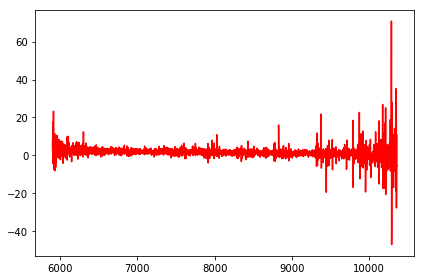

In [248]:
x = wlen_plate3586_fiber1000_exposure08
y = flux_plate3586_fiber1000_exposure08
plt.plot(x,y,c='r')
plt.tight_layout()
plt.show()

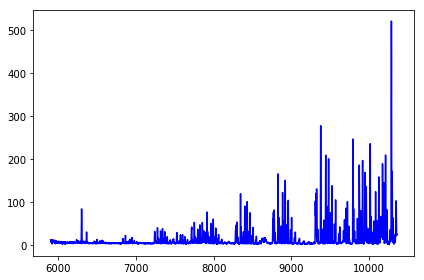

In [245]:
x = wlen_plate3586_fiber1000_exposure08
y = sky_plate3586_fiber1000_exposure08
plt.plot(x,y,c = 'b')
plt.tight_layout()
plt.show()

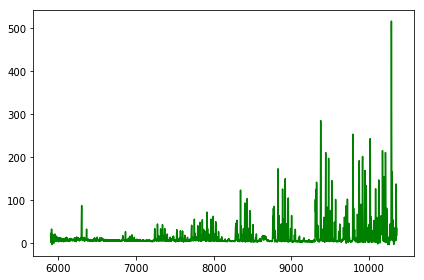

In [247]:
x = wlen_plate3586_fiber1000_exposure08
y = sky_plate3586_fiber1000_exposure08 + flux_plate3586_fiber1000_exposure08 
plt.plot(x,y,c = 'g')
plt.tight_layout()
plt.show()

In [228]:
data_plate3586_fiber1000_exposure08.shape

(3154,)

Wavelength of a particular integral pixel.

In [200]:
spec.fiducial_loglam[100]

3.554100305027835

Bounding wavelength range

In [198]:
10**spec.fiducial_loglam[[0,-1]]

array([ 3500.26      , 10568.18251472])